In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.constants import constants as sc
from scipy.special import ellipk

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context("poster")
sns.set_style("ticks",{"xtick.direction" : u"in",
                       "ytick.direction" : u"in"})
sns.set_palette(sns.color_palette("coolwarm", 4))

In [4]:
class PhysicalProperties(object):
    def __init__(self,a=None,b=None,d=None,pen_depth=None):
        self._a = a
        self._b = b
        self._d = d
        self._pen_depth = pen_depth
        
        return 
    
    @property
    def a(self): 
        return self._a
    
    @a.setter 
    def a(self, a): 
        self._a = a 
        
    @property
    def b(self): 
        return self._b
    
    @b.setter 
    def b(self, b): 
        self._b = b 
        
    @property
    def d(self): 
        return self._d
    
    @d.setter 
    def d(self, d): 
        self._d = d
    
    @property
    def pen_depth(self): 
        return self._pen_depth
    
    @pen_depth.setter 
    def pen_depth(self, pen_depth): 
        self._pen_depth = pen_depth 
        
    # Modulus of complete elliptic integral of first kind
    @property
    def k(self): 
        return self._a / self._b
    
    # Complementary modulus of complete elliptic integral of first kind
    @property
    def kp(self): 
        return np.sqrt(1-self.k**2)
    
    @property
    def qu(self):
        u = self._d / self._pen_depth
        return (np.sinh(u) + u) / (8*np.sinh(u/2)**2)

In [5]:
class EMProperties(PhysicalProperties):
    
    def __init__(self, a=None, b=None, d=None, pen_depth=None):
        super().__init__(a=a, b=b, d=d, pen_depth=pen_depth)
    
    def current_density(self,xlist,A=1):
        Kz = []
        for x in xlist:
            if abs(x) < self._a:
                Kz.append( 2*A / ( np.sqrt( (self._a**2 - x**2)*(self._b**2 - x**2) )) )
            elif abs(x) > self._b:
                Kz.append( -2*A / ( np.sqrt( (x**2 - self._a**2)*(x**2 - self._b**2) )) )

        # pad out Kz to make it the right length
        ls = int(.5*(len(xlist)-len(Kz)))
        klhs = Kz[0]*np.ones(ls)
        krhs = Kz[len(Kz)-1]*np.ones(ls)
        Kz = list(np.concatenate((np.concatenate((klhs,Kz)),krhs)))
        return Kz

    def complex_field(self,xlist,A=1):
        Hy = []

        for i in range(len(xlist)):
            mod1 = xlist[i]**2 - self._a**2
            mod2 = self._b**2 - xlist[i]**2
            if xlist[i] < self._a:
                Hy.append( -self._a / ( (abs(xlist[i]) * np.sqrt(mod1 * mod2)) ) )
            if xlist[i] > self._a:
                Hy.append( self._a / ( (abs(xlist[i]) * np.sqrt(mod1 * mod2)) ) )
        return(Hy)
    
    def get_geometric_inductance(self):
        Lml = (sc.mu_0 * ellipk(self.kp)) / ellipk(self.k)
        for i in range(len(Lml)):
            if np.isnan(Lml[i]):
                Lml[i] = 0
        return Lml
    
    def get_Lml_approximate1(self):
        Lml1 = (sc.mu_0)/(2*np.pi) * (np.log(4*self._b/self._a) - (self._a/2*self._b)**2)

        for i in range(len(Lml1)):
            if np.isnan(Lml1[i]):
                Lml1[i] = 0
        return Lml1
    
    def get_Lml_approximate2(self):
        Lml2 = ((np.pi*sc.mu_0)/4) / np.log((8*self._a)/(self._b-self._a))

        for i in range(len(Lml2)):
            if np.isnan(Lml2[i]):
                Lml2[i] = 0
        return Lml2

    def supercurrent(self,xlist):
        return np.array( [(k**2)*self.qu for k in self.current_density(xlist)] )
    
    def g_clem(self,ec):
        l1 = (1/(2*(1-self.k)))
        l2 = ec*(1+self.k)
        return ( 1/( 2*(1-self.k) * ellipk(self.k)**2 ) ) * np.log( l1/l2 )
    
    def kinetic_inductance_clem_1(self,ec):
        return ( (sc.mu_0*self._pen_depth) / (2*self._a) ) * self.qu * self.g_clem(ec)
    
    def g_watanabe(self,w,s,t):
        k = w/(w+2*s)
        g = (1/(2*(1-k**2)*ellipk(k)**2))*( -np.log(t/(4*w)) - (w/(w+2*s))*np.log(t/(4*(w+2*s))) + ((2*(w+2*s))/(w+2*s)) *np.log(s/(w+s)) )
        return g
    
    def kinetic_inductance_watanabe(self,w,s):
        return sc.mu_0 * (self._pen_depth**2 /(w*self._d)) * self.g_watanabe(w,s,self._d) 

In [6]:
em = EMProperties(a=1, b=2, d=50e-09, pen_depth=33.3e-09)

xlist = np.arange(-4,4,0.0005)
Kz = em.current_density(xlist)
Hy = em.complex_field(xlist)

/Users/garethjones/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt
/Users/garethjones/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt


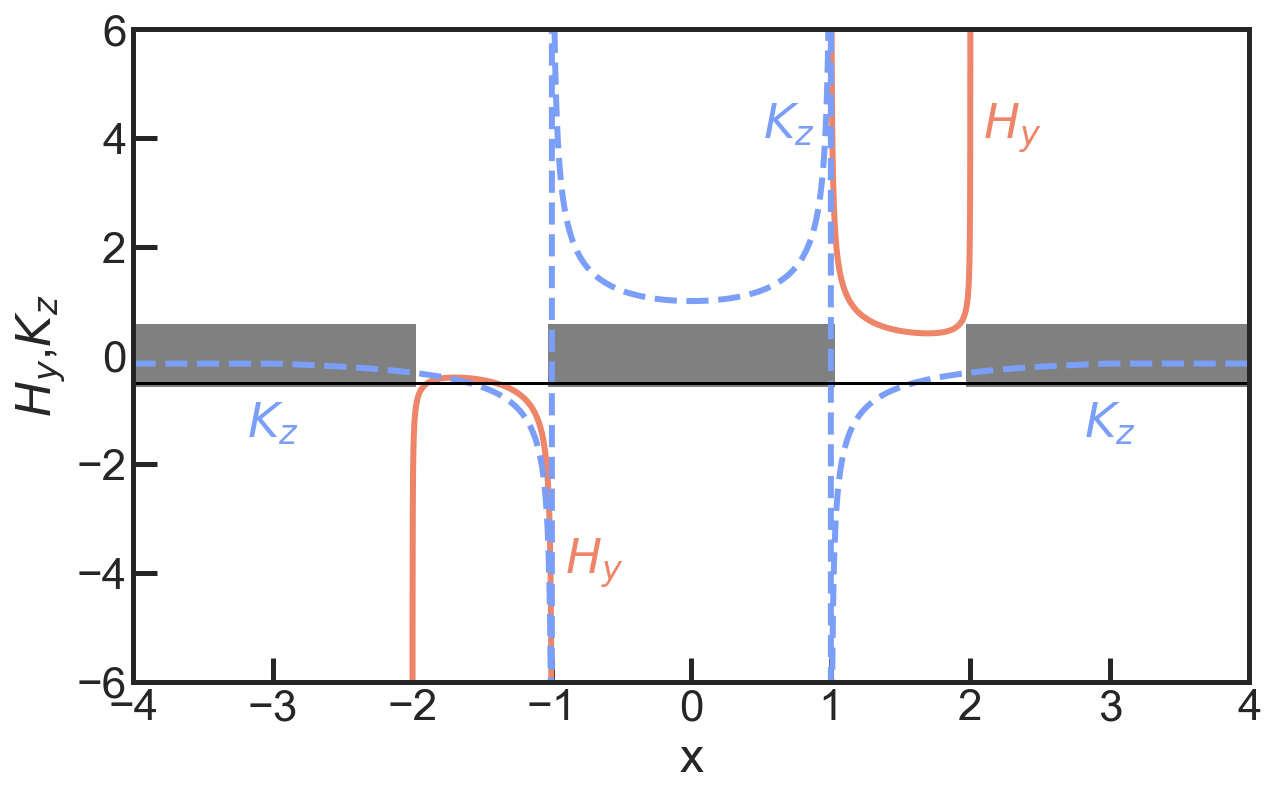

In [7]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(10,6))
ax0 = fig.add_subplot(111)
ax0.plot(xlist,Hy,color=sns.color_palette()[3])
ax0.plot(xlist,Kz,'--')
ax0.set_xlim(-4,4)
ax0.set_ylim(-6,6)
ax0.set_xlabel('x')
ax0.set_ylabel('$H_{y}$,$K_{z}$')

ax0.text(-3,-1.5,'$K_{z}$',horizontalalignment='center',
        color=sns.color_palette()[0])
ax0.text(-.7,-4,'$H_{y}$',horizontalalignment='center',
        color=sns.color_palette()[3])

ax0.text(.7,4,'$K_{z}$',horizontalalignment='center',
        color=sns.color_palette()[0])
ax0.text(2.3,4,'$H_{y}$',horizontalalignment='center',
        color=sns.color_palette()[3])

ax0.text(3,-1.5,'$K_{z}$',horizontalalignment='center',
        color=sns.color_palette()[0])

ax0.axhline(-0.5, color='k',linewidth=1.5)
rect1 = patches.Rectangle((-1,-.5),2,1,linewidth=4,edgecolor='gray',facecolor='gray')
rect2 = patches.Rectangle((-4,-.5),2,1,linewidth=4,edgecolor='gray',facecolor='gray')
rect3 = patches.Rectangle((2,-.5),2,1,linewidth=4,edgecolor='gray',facecolor='gray')
ax0.add_patch(rect1)
ax0.add_patch(rect2)
ax0.add_patch(rect3)

plt.savefig('figs/ClemFig1_Hy_and_Kz.pdf',bbox_inches=None)
plt.show()

In [8]:
em.a = 5e-06
em.b = np.arange(0.1e-06,16e-06,0.05e-06)

L1 = em.get_geometric_inductance()
L2 = em.get_Lml_approximate1()
L3 = em.get_Lml_approximate2()

/Users/garethjones/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt
/Users/garethjones/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log


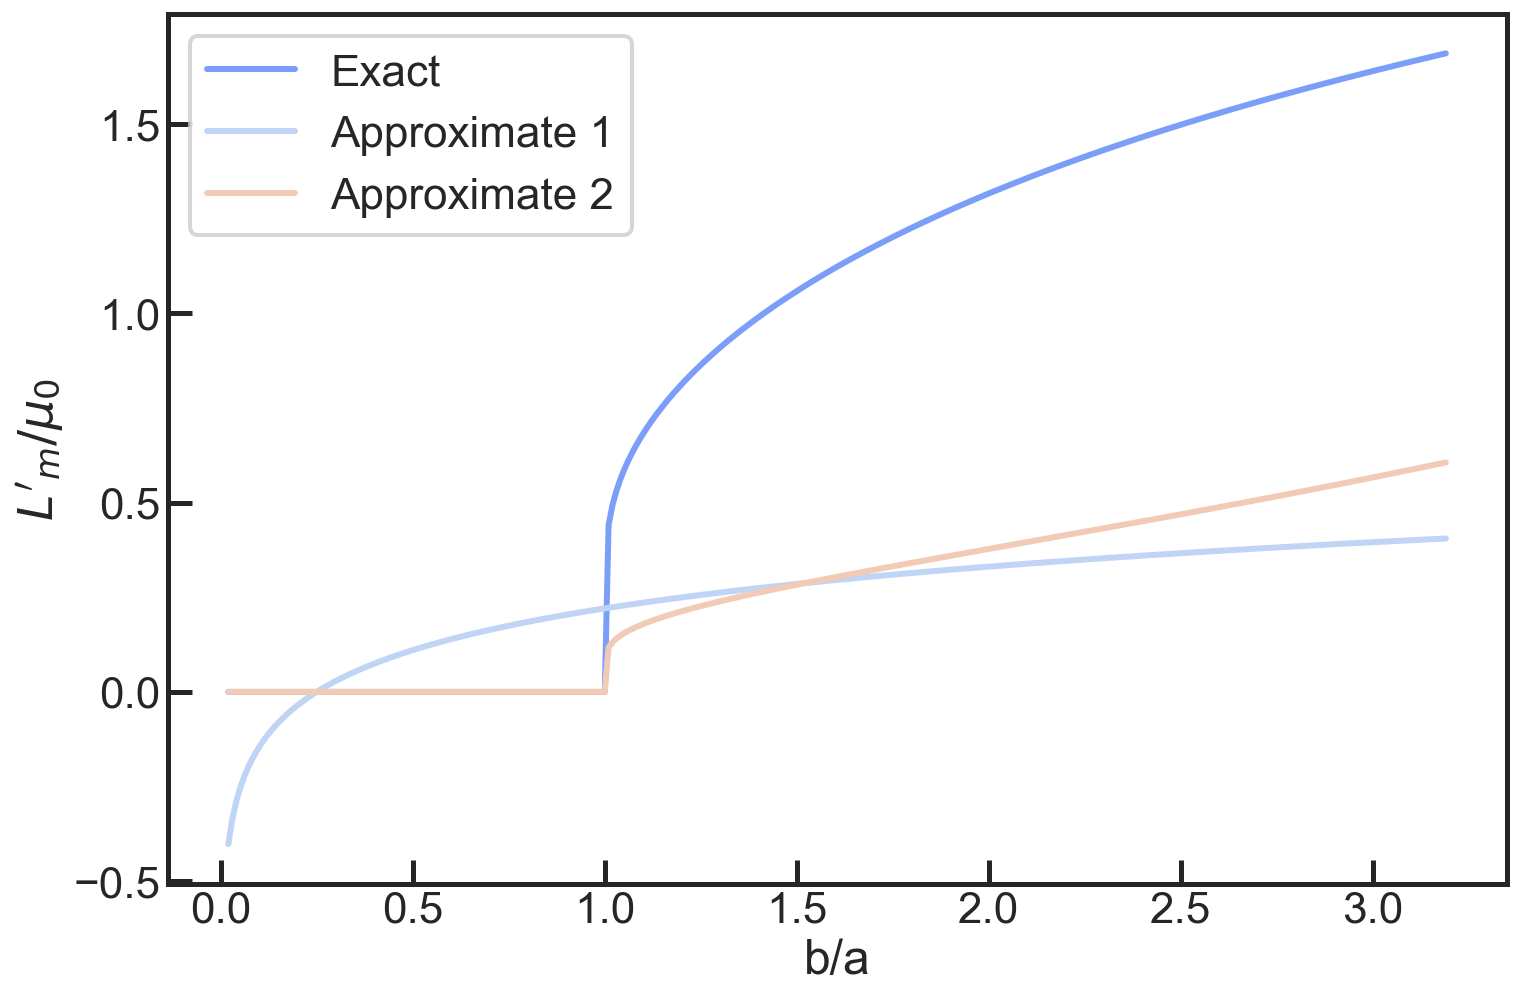

In [9]:
plt.figure(figsize=(12,8))
plt.plot(em.b/em.a,L1/sc.mu_0,label="Exact")
plt.plot(em.b/em.a,L2/sc.mu_0,label="Approximate 1")
plt.plot(em.b/em.a,L3/sc.mu_0,label="Approximate 2")

plt.xlabel("b/a")
plt.ylabel("$L'_{m}/\mu_{0}$")

plt.legend()
plt.savefig('figs/ClemFig3_Lm_with_approxs.pdf',bbox_inches=None)
plt.show()

In [10]:
em.a = 1
em.b = 2
supercurrent = em.supercurrent(xlist)

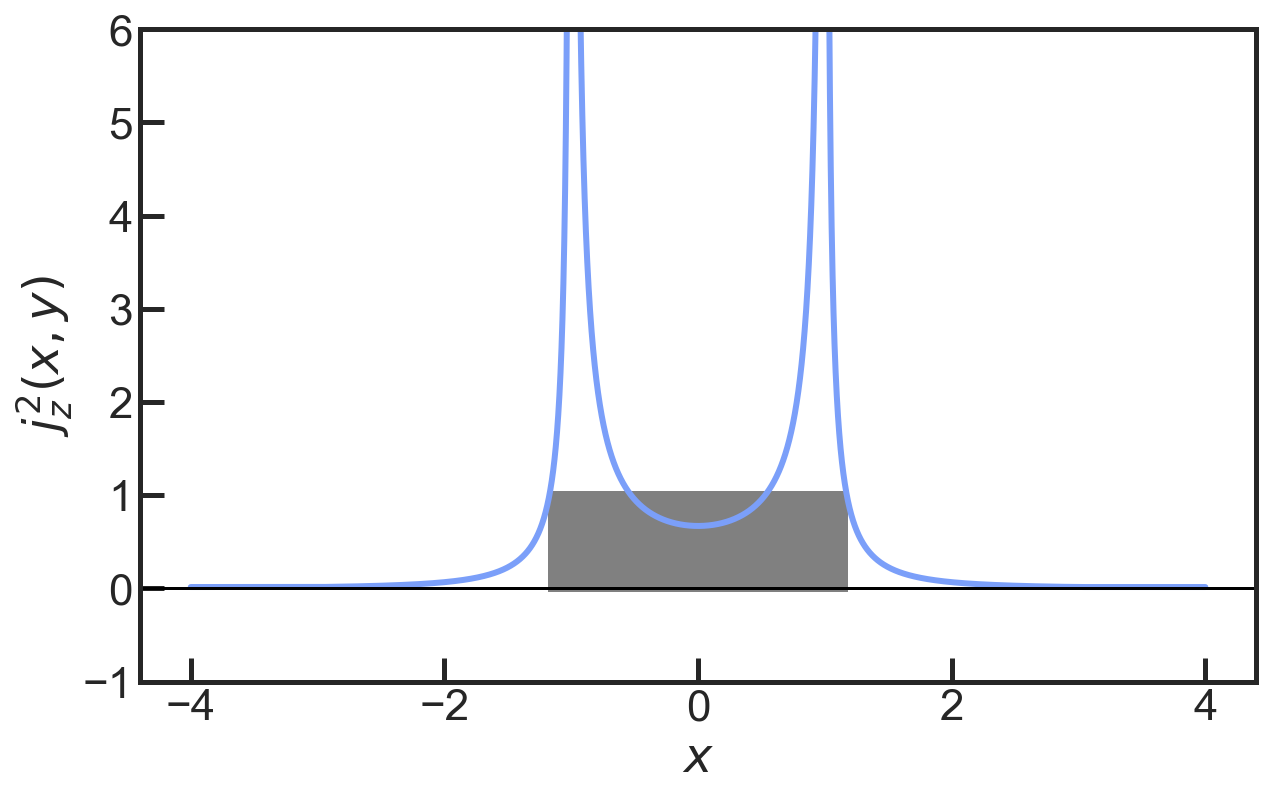

In [11]:
fig = plt.figure(figsize=(10,6))
ax0 = fig.add_subplot(111)
ax0.plot(xlist,supercurrent)
ax0.set_ylim(-1,6)
ax0.set_xlabel("$x$")
ax0.set_ylabel("$j^{2}_{z}(x,y)$")

ax0.axhline(0, color='k',linewidth=1.5)
rect = patches.Rectangle((-1.15,0),2.3,1,linewidth=4,edgecolor='gray',facecolor='gray')
ax0.add_patch(rect)

plt.savefig('figs/jz_from_section_IIB.pdf',bbox_inches=None)
plt.show()

In [28]:
# Clem
em.a = 5e-06
em.b = np.arange(5.05e-06,16e-06,0.05e-06)

# ec = em.pen_depth/4
ec = em.d/4
# ec = (2*em.pen_depth)/em.d
Lki_clem1 = em.kinetic_inductance_clem_1(ec)

# Watanabe
w = 2*em.a
s = 2*em.b - w

Lki_watanabe = em.kinetic_inductance_watanabe(w,s) 

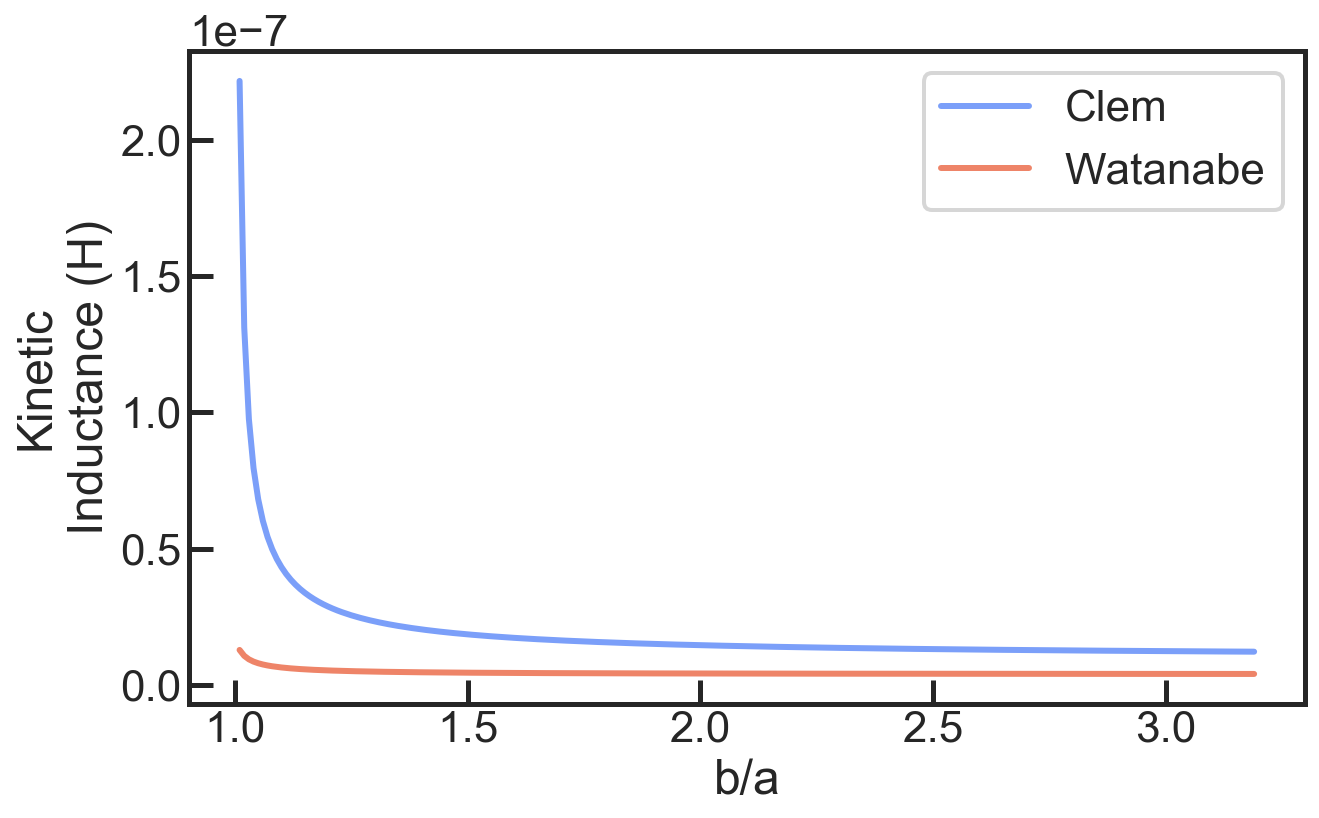

In [29]:
plt.figure(figsize=(10,6))
plt.plot(em.b/em.a,Lki_clem1,label='Clem')
plt.plot(em.b/em.a,Lki_watanabe,color=sns.color_palette()[3],label='Watanabe')
plt.xlabel('b/a')
plt.ylabel('Kinetic\nInductance (H)')
plt.legend()
# plt.savefig('figs/Lki_from_section_IIB.pdf',bbox_inches=None)
plt.show()

In [31]:
# Clem
em.a = 5e-06
em.b = np.arange(5.05e-06,16e-06,0.05e-06)

ec_low = (2*em.pen_depth**2)/em.d
ec_high = em.d/4
Lki_clem_eclow = em.kinetic_inductance_clem_1(ec_low)
Lki_clem_echigh = em.kinetic_inductance_clem_1(ec_high)

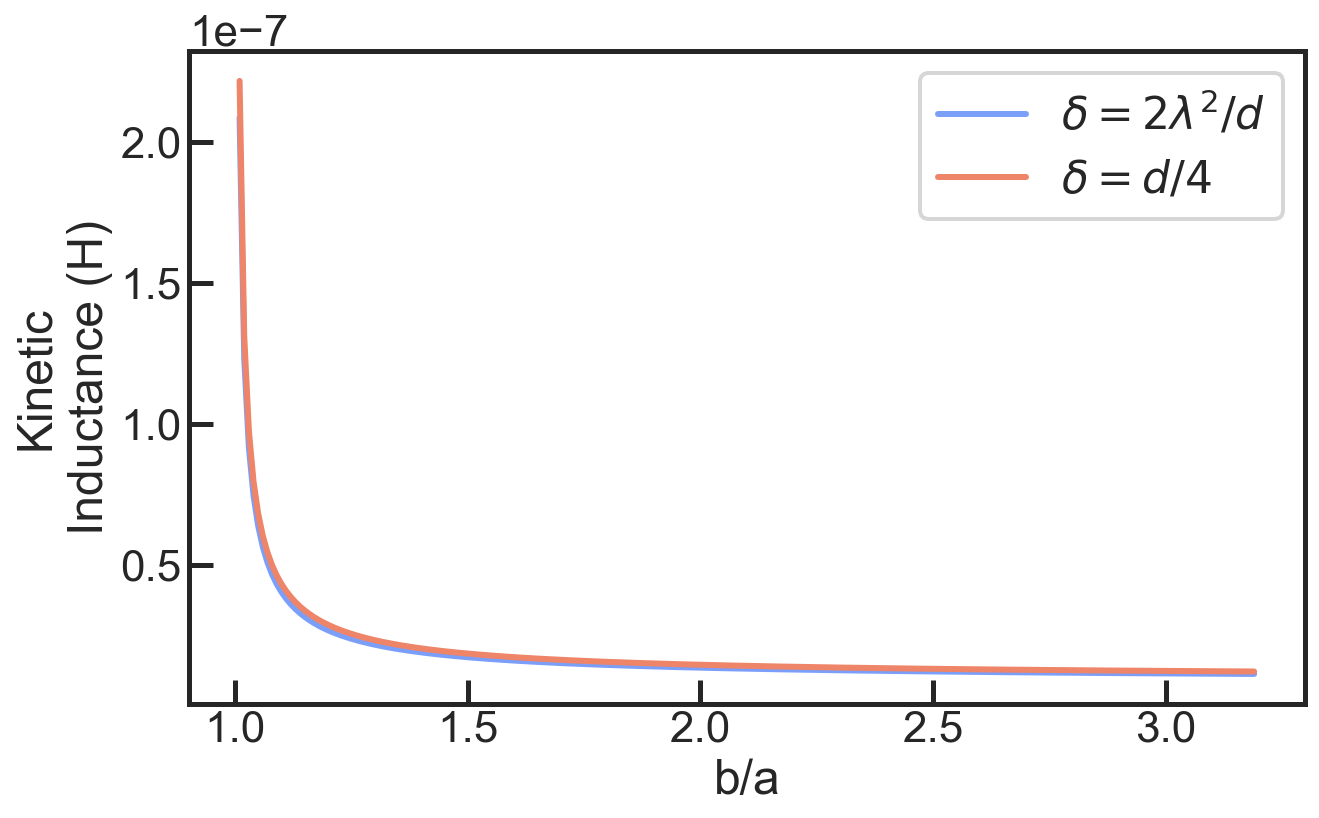

In [89]:
plt.figure(figsize=(10,6))
plt.plot(em.b/em.a,Lki_clem_eclow,label='$\delta=2\lambda^{2} /d$')
plt.plot(em.b/em.a,Lki_clem_echigh,color=sns.color_palette()[3],label='$\delta = d/4$')
plt.xlabel('b/a')
plt.ylabel('Kinetic\nInductance (H)')
plt.legend()
plt.savefig('figs/compare_Clem_Lki_w_ec.pdf',bbox_inches=None)
plt.show()

In [70]:
dlist = np.arange(5e-09,65e-09,5e-09)

a = 5e-06
b = np.arange(5.01e-06,5.05e-06,0.001e-06)

em_sweep_d = [EMProperties(a=a, b=b, d=d, pen_depth=33.3e-09) for d in dlist]

ec_low = (2*em.pen_depth**2)/em.d
ec_high = em.d/4

Lki_clem_eclow = em.kinetic_inductance_clem_1(ec_low)
# Lki_clem_echigh = em.kinetic_inductance_clem_1(ec_high)

In [71]:
Lklow_sweep = [em_sweep_d[i].kinetic_inductance_clem_1(ec_low) for i in range(len(em_sweep_d))]
Lkhigh_sweep = [em_sweep_d[i].kinetic_inductance_clem_1(ec_high) for i in range(len(em_sweep_d))]

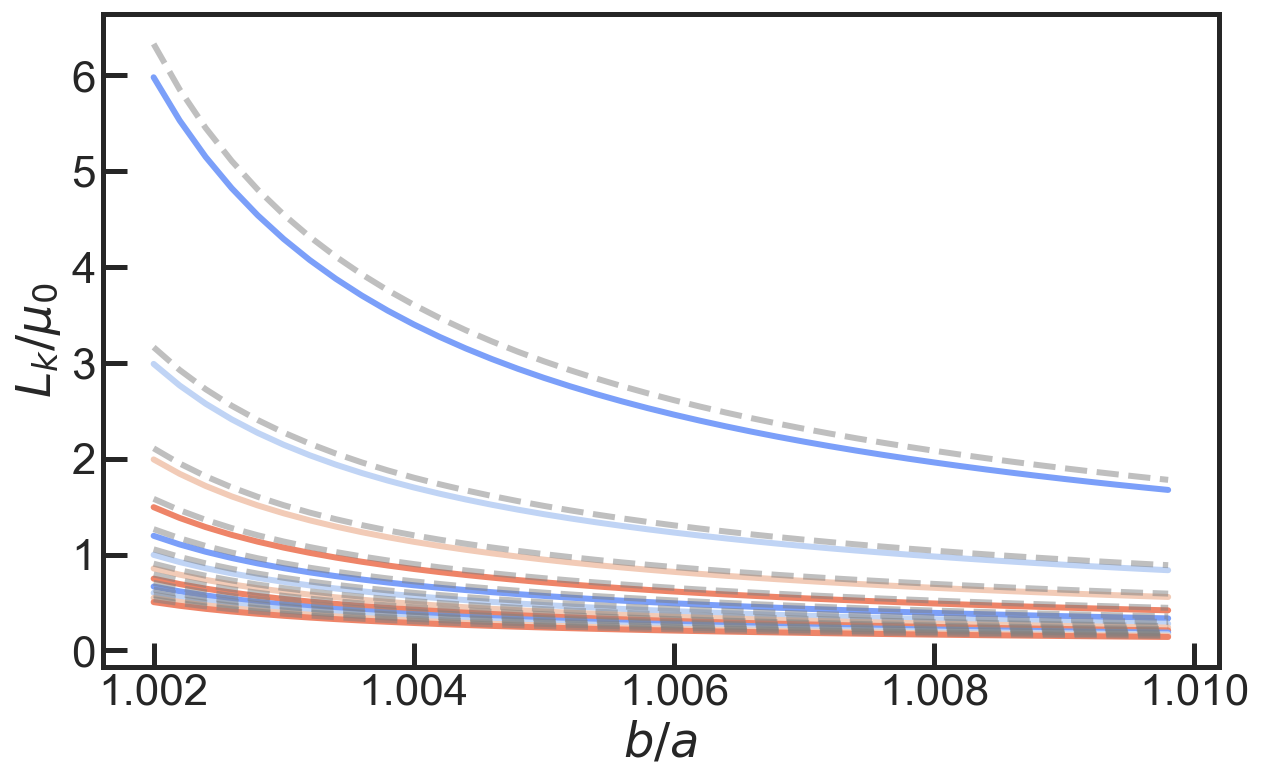

In [88]:
plt.figure(figsize=(10,6))
[plt.plot(em_sweep_d[0].b/em_sweep_d[0].a,Lklow_sweep[i]/sc.mu_0) for i in range(len(Lklow_sweep))]
[plt.plot(em_sweep_d[0].b/em_sweep_d[0].a,Lkhigh_sweep[i]/sc.mu_0,'--',color='gray',alpha=.5) for i in range(len(Lkhigh_sweep))]

plt.xlabel('$b/a$')
plt.ylabel('$L_{k}/\mu_{0}$')
plt.show()